# Final

We will retrain our models to have them in one place and make sure that the shap values are being generated properly. We will also turn our second model into binary to make the generation of shap values simpler and faster.

In [1]:
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import imblearn.over_sampling as oversampling
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import evaluate_metrics, plot_roc_curve, optimize_threshold

## Model 1 with shap testing
There is no need for scaling, since we are using CatBoost

In [2]:
df1 = pd.read_parquet("diabetes_dataset_prepared.parquet")
df1.head()

,family_history_diabetes,hypertension_history,cardiovascular_history,waist_to_hip_ratio,glucose_fasting,glucose_postprandial,hba1c,diagnosed_diabetes,glucose_fasting_times_hba1c,glucose_postprandial_times_hba1c,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,age_80+,gender_Male,gender_Other,ethnicity_Black,ethnicity_Hispanic,ethnicity_Other,ethnicity_White,education_level_Highschool,education_level_No formal,education_level_Postgraduate,income_level_Low,income_level_Lower-Middle,income_level_Middle,income_level_Upper-Middle,employment_status_Retired,employment_status_Student,employment_status_Unemployed,smoking_status_Former,smoking_status_Never,alcohol_consumption_per_week_Light,alcohol_consumption_per_week_Moderate,alcohol_consumption_per_week_Heavy,physical_activity_minutes_per_week_Light,physical_activity_minutes_per_week_Moderate,physical_activity_minutes_per_week_Active,physical_activity_minutes_per_week_Very Active,diet_score_Fair,diet_score_Good,diet_score_Excellent,sleep_hours_per_day_Short,sleep_hours_per_day_Normal,sleep_hours_per_day_Long,screen_time_hours_per_day_Moderate,screen_time_hours_per_day_High,screen_time_hours_per_day_Very_High,bmi_Normal,bmi_Overweight,bmi_Obese_I,bmi_Obese_II,systolic_bp_Elevated,systolic_bp_HTN_Stage_1,systolic_bp_HTN_Stage_2,diastolic_bp_HTN_Stage_1,diastolic_bp_HTN_Stage_2,heart_rate_Normal,heart_rate_Tachycardia,cholesterol_total_Borderline_high,cholesterol_total_High,hdl_cholesterol_Normal,hdl_cholesterol_High,ldl_cholesterol_Near_optimal,ldl_cholesterol_Borderline_high,ldl_cholesterol_High,ldl_cholesterol_Very_high,triglycerides_Borderline_high,triglycerides_High,insulin_level_Normal,insulin_level_High
0,0,0,0,0.89,136,236,8.18,1,1112.479980,1930.480103,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0.80,93,150,5.63,0,523.590027,844.500000,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,0,0,0.81,118,195,7.51,1,886.180054,1464.450073,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0.88,139,253,9.03,1,1255.169922,2284.589844,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0.78,137,184,7.20,1,986.399963,1324.799927,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0


In [3]:
chosen_features1 = ["glucose_fasting", "hba1c"]

X1 = df1[chosen_features1]
y1 = df1["diagnosed_diabetes"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, test_size=0.2, shuffle=True, random_state=42, stratify=y1
)

In [4]:
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'bagging_temperature': [0, 0.2, 0.5, 0.8, 1],
    'iterations': [500, 1000, 1500]
}

cbc = CatBoostClassifier(eval_metric='F1', verbose=0)
random_search = RandomizedSearchCV(
    cbc, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1
)

random_search.fit(X_train1, y_train1)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.01, 'l2_leaf_reg': 10, 'iterations': 1000, 'depth': 8, 'bagging_temperature': 0}


In [5]:
model1 = CatBoostClassifier(**best_params, random_seed=2025, verbose=0)
model1.fit(X_train1, y_train1)

y_train_pred1 = model1.predict(X_train1)
y_test_pred1 = model1.predict(X_test1)

Training Set Metrics:


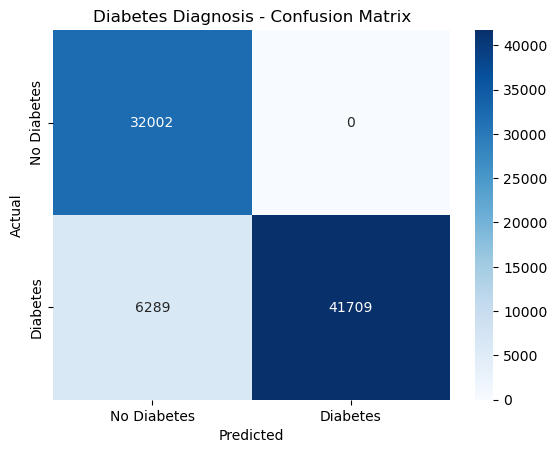

Accuracy: 0.9213875
Precision: 1.0
Recall: 0.8689737072378015
F1 Score: 0.9298939882060486


Test Set Metrics:


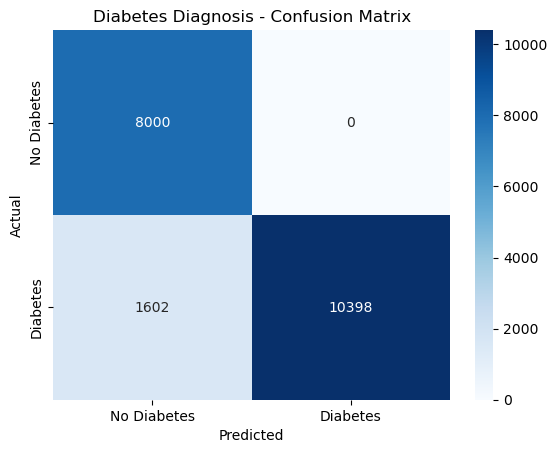

Accuracy: 0.9199
Precision: 1.0
Recall: 0.8665
F1 Score: 0.9284757567639967


In [6]:
evaluate_metrics(y_train1, y_train_pred1, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test1, y_test_pred1, "Test Set Metrics:")

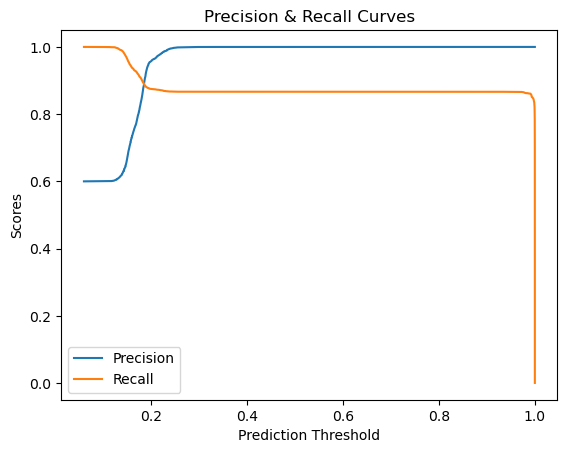

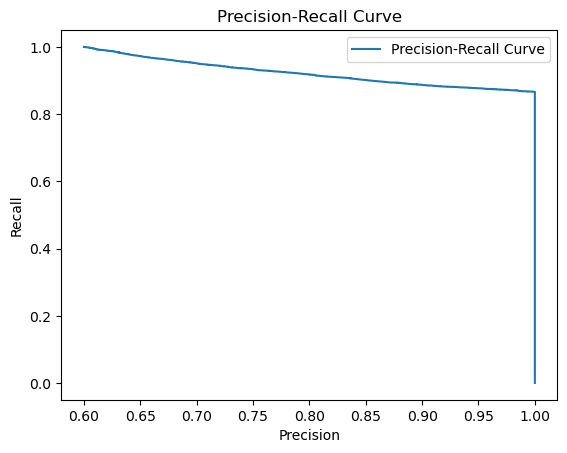

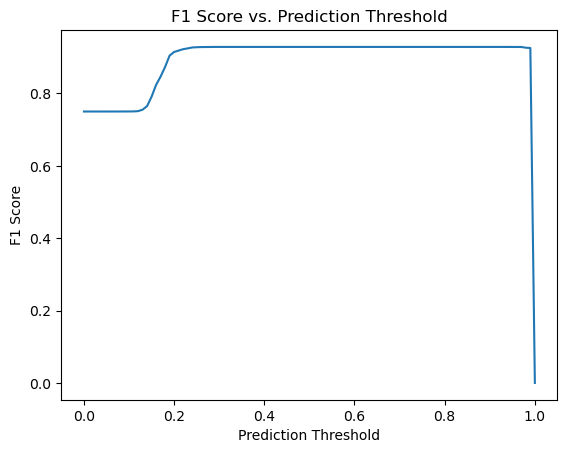

Optimal threshold: 0.3


In [7]:
y_train_pred_proba1 = model1.predict_proba(X_train1)[:, 1]
y_test_pred_proba1 = model1.predict_proba(X_test1)[:, 1]

thresh1 = optimize_threshold(y_test1, y_test_pred_proba1)
print(f"Optimal threshold: {thresh1}")

Training Set Metrics with Optimized Threshold:


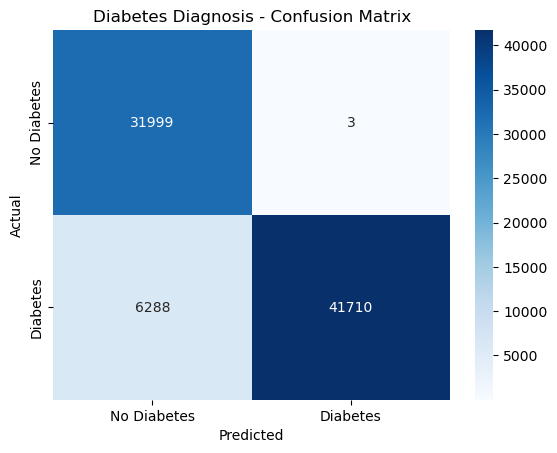

Accuracy: 0.9213625
Precision: 0.9999280799750677
Recall: 0.8689945414392266
F1 Score: 0.9298748202561559


Test Set Metrics with Optimized Threshold:


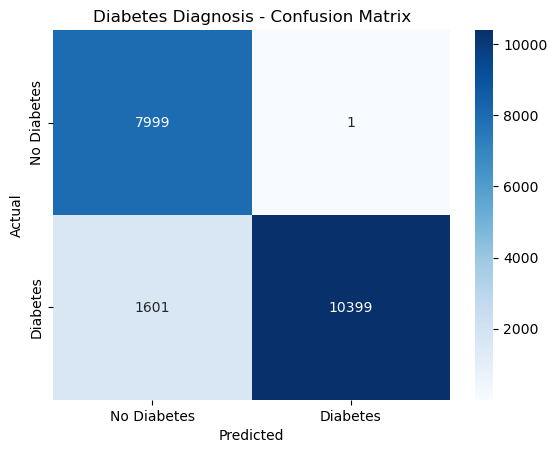

Accuracy: 0.9199
Precision: 0.9999038461538462
Recall: 0.8665833333333334
F1 Score: 0.9284821428571428


In [8]:
preds_train1 = y_train_pred_proba1 >= thresh1
preds_test1 = y_test_pred_proba1 >= thresh1

evaluate_metrics(y_train1, preds_train1, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test1, preds_test1, "Test Set Metrics with Optimized Threshold:")

This is roughly the performance we expected. We can now check the shap values.

In [12]:
explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(X_test1.sample(100, random_state=42))
shap_df1 = pd.DataFrame(shap_values1, columns=chosen_features1)
shap_df1.head()

,glucose_fasting,hba1c
0,0.049078,3.584079
1,0.662444,5.513286
2,-0.498646,-5.506642
3,-0.820327,-5.311451
4,0.415338,5.283176


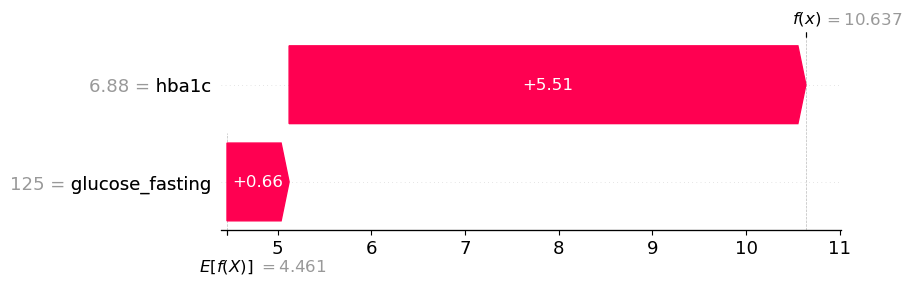

In [22]:
# create a SHAP Explanation object for a single sample and plot the waterfall
# idx = range(100)[0]  # first sample in the SHAP values

idx = 1  # first sample in the SHAP values

base = explainer1.expected_value
# if expected_value is an array (e.g. per-class), use the positive class value
if hasattr(base, "__len__") and len(base) > 1:
	base = base[1]

exp = shap.Explanation(
	values=shap_values1[idx],
	base_values=base,
	data=X_test1.iloc[idx].values,
	feature_names=list(X_test1.columns)
)

shap.plots.waterfall(exp)

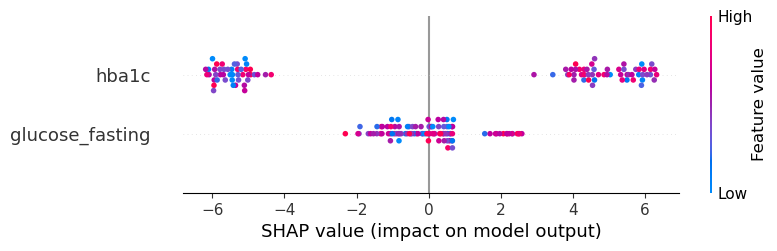

In [23]:
idx = list(range(1, 100))
base = explainer1.expected_value

if hasattr(base, "__len__") and len(base) > 1:
	base = base[1]

exp = shap.Explanation(
	values=shap_values1[idx],
	base_values=base,
	data=X_test1.iloc[idx].values,
	feature_names=list(X_test1.columns)
)

shap.plots.beeswarm(exp)

All works well. Now we will save model1 and move on to model2.

In [26]:
joblib.dump(model1, "models/model1.pkl")

['models/model1.pkl']

## Model 2 with shap testing

In [2]:
df2 = pd.read_parquet("diabetes_dataset_prepared_2.parquet")
df2.head()

,family_history_diabetes,hypertension_history,cardiovascular_history,waist_to_hip_ratio,glucose_fasting,glucose_postprandial,hba1c,diabetes_risk_score,glucose_fasting_times_hba1c,glucose_postprandial_times_hba1c,...,hdl_cholesterol_Normal,hdl_cholesterol_High,ldl_cholesterol_Near_optimal,ldl_cholesterol_Borderline_high,ldl_cholesterol_High,ldl_cholesterol_Very_high,triglycerides_Borderline_high,triglycerides_High,insulin_level_Normal,insulin_level_High
0,0,0,0,0.89,136,236,8.18,0,1112.479980,1930.480103,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0.80,93,150,5.63,0,523.590027,844.500000,...,1,0,0,0,0,0,0,0,1,0
2,1,0,0,0.81,118,195,7.51,1,886.180054,1464.450073,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0.88,139,253,9.03,0,1255.169922,2284.589844,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0.78,137,184,7.20,0,986.399963,1324.799927,...,1,0,1,0,0,0,1,0,1,0


Since we are going to train this as a binary model, we will once again choose the best features.

In [3]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df2.drop(columns=["diabetes_risk_score"]),
    df2["diabetes_risk_score"],
    test_size=0.2,
    random_state=2025,
    stratify=df2["diabetes_risk_score"]
)

In [4]:
n_low = np.sum(y_train2 == 0)
n_high = np.sum(y_train2 == 1)

print(f"Low risk samples: {n_low}")
print(f"High risk samples: {n_high}")

Low risk samples: 67249
High risk samples: 12751


In [5]:
ratio = {0: n_low, 1: round(n_high * 5)}

smt = oversampling.SMOTE(sampling_strategy=ratio, random_state=2025)

X_train2, y_train2 = smt.fit_resample(X_train2, y_train2)

print("After resampling:")
print(y_train2.value_counts())

After resampling:
diabetes_risk_score
0    67249
1    63755
Name: count, dtype: int64


In [6]:
cat_untuned1 = CatBoostClassifier(random_seed=2025, verbose=0)
cat_untuned1.fit(X_train2, y_train2)

y_train_pred2 = cat_untuned1.predict(X_train2)
y_test_pred2 = cat_untuned1.predict(X_test2)

Training Set Metrics:


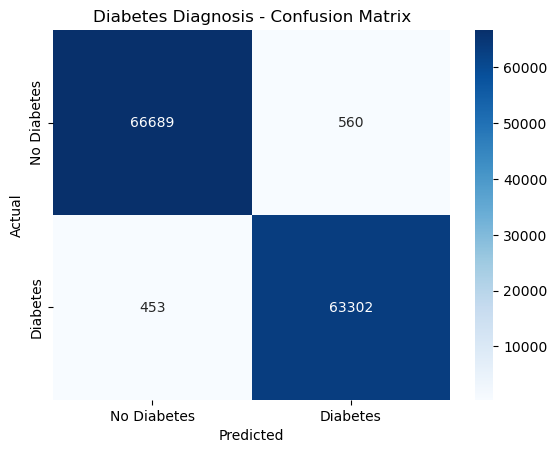

Accuracy: 0.9922674116820861
Precision: 0.991231092042216
Recall: 0.9928946749274566
F1 Score: 0.9920621860723885


Test Set Metrics:


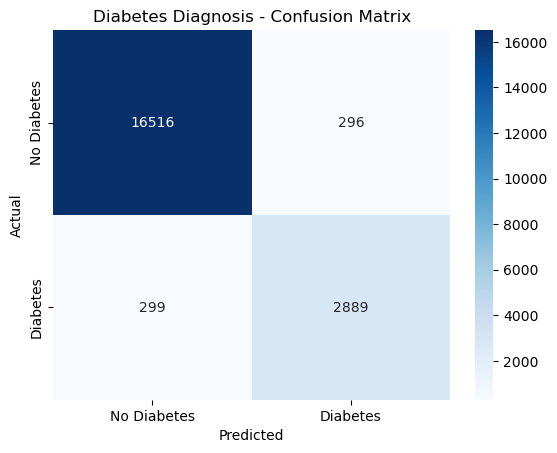

Accuracy: 0.97025
Precision: 0.9070643642072214
Recall: 0.9062107904642409
F1 Score: 0.9066373764318217


In [7]:
evaluate_metrics(y_train2, y_train_pred2, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test2, y_test_pred2, "Test Set Metrics:")

In [8]:
feature_importances = cat_untuned1.get_feature_importance(Pool(X_train2, label=y_train2))
feature_names = df2.drop(columns=['diabetes_risk_score']).columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                      Feature  Importance
0                     family_history_diabetes   25.878798
10                                  age_40-49    7.604066
11                                  age_50-59    5.888737
38  physical_activity_minutes_per_week_Active    5.592032
3                          waist_to_hip_ratio    5.189680
..                                        ...         ...
67                  ldl_cholesterol_Very_high    0.011143
52                               bmi_Obese_II    0.008615
71                         insulin_level_High    0.001301
59                     heart_rate_Tachycardia    0.000184
70                       insulin_level_Normal    0.000000

[72 rows x 2 columns]


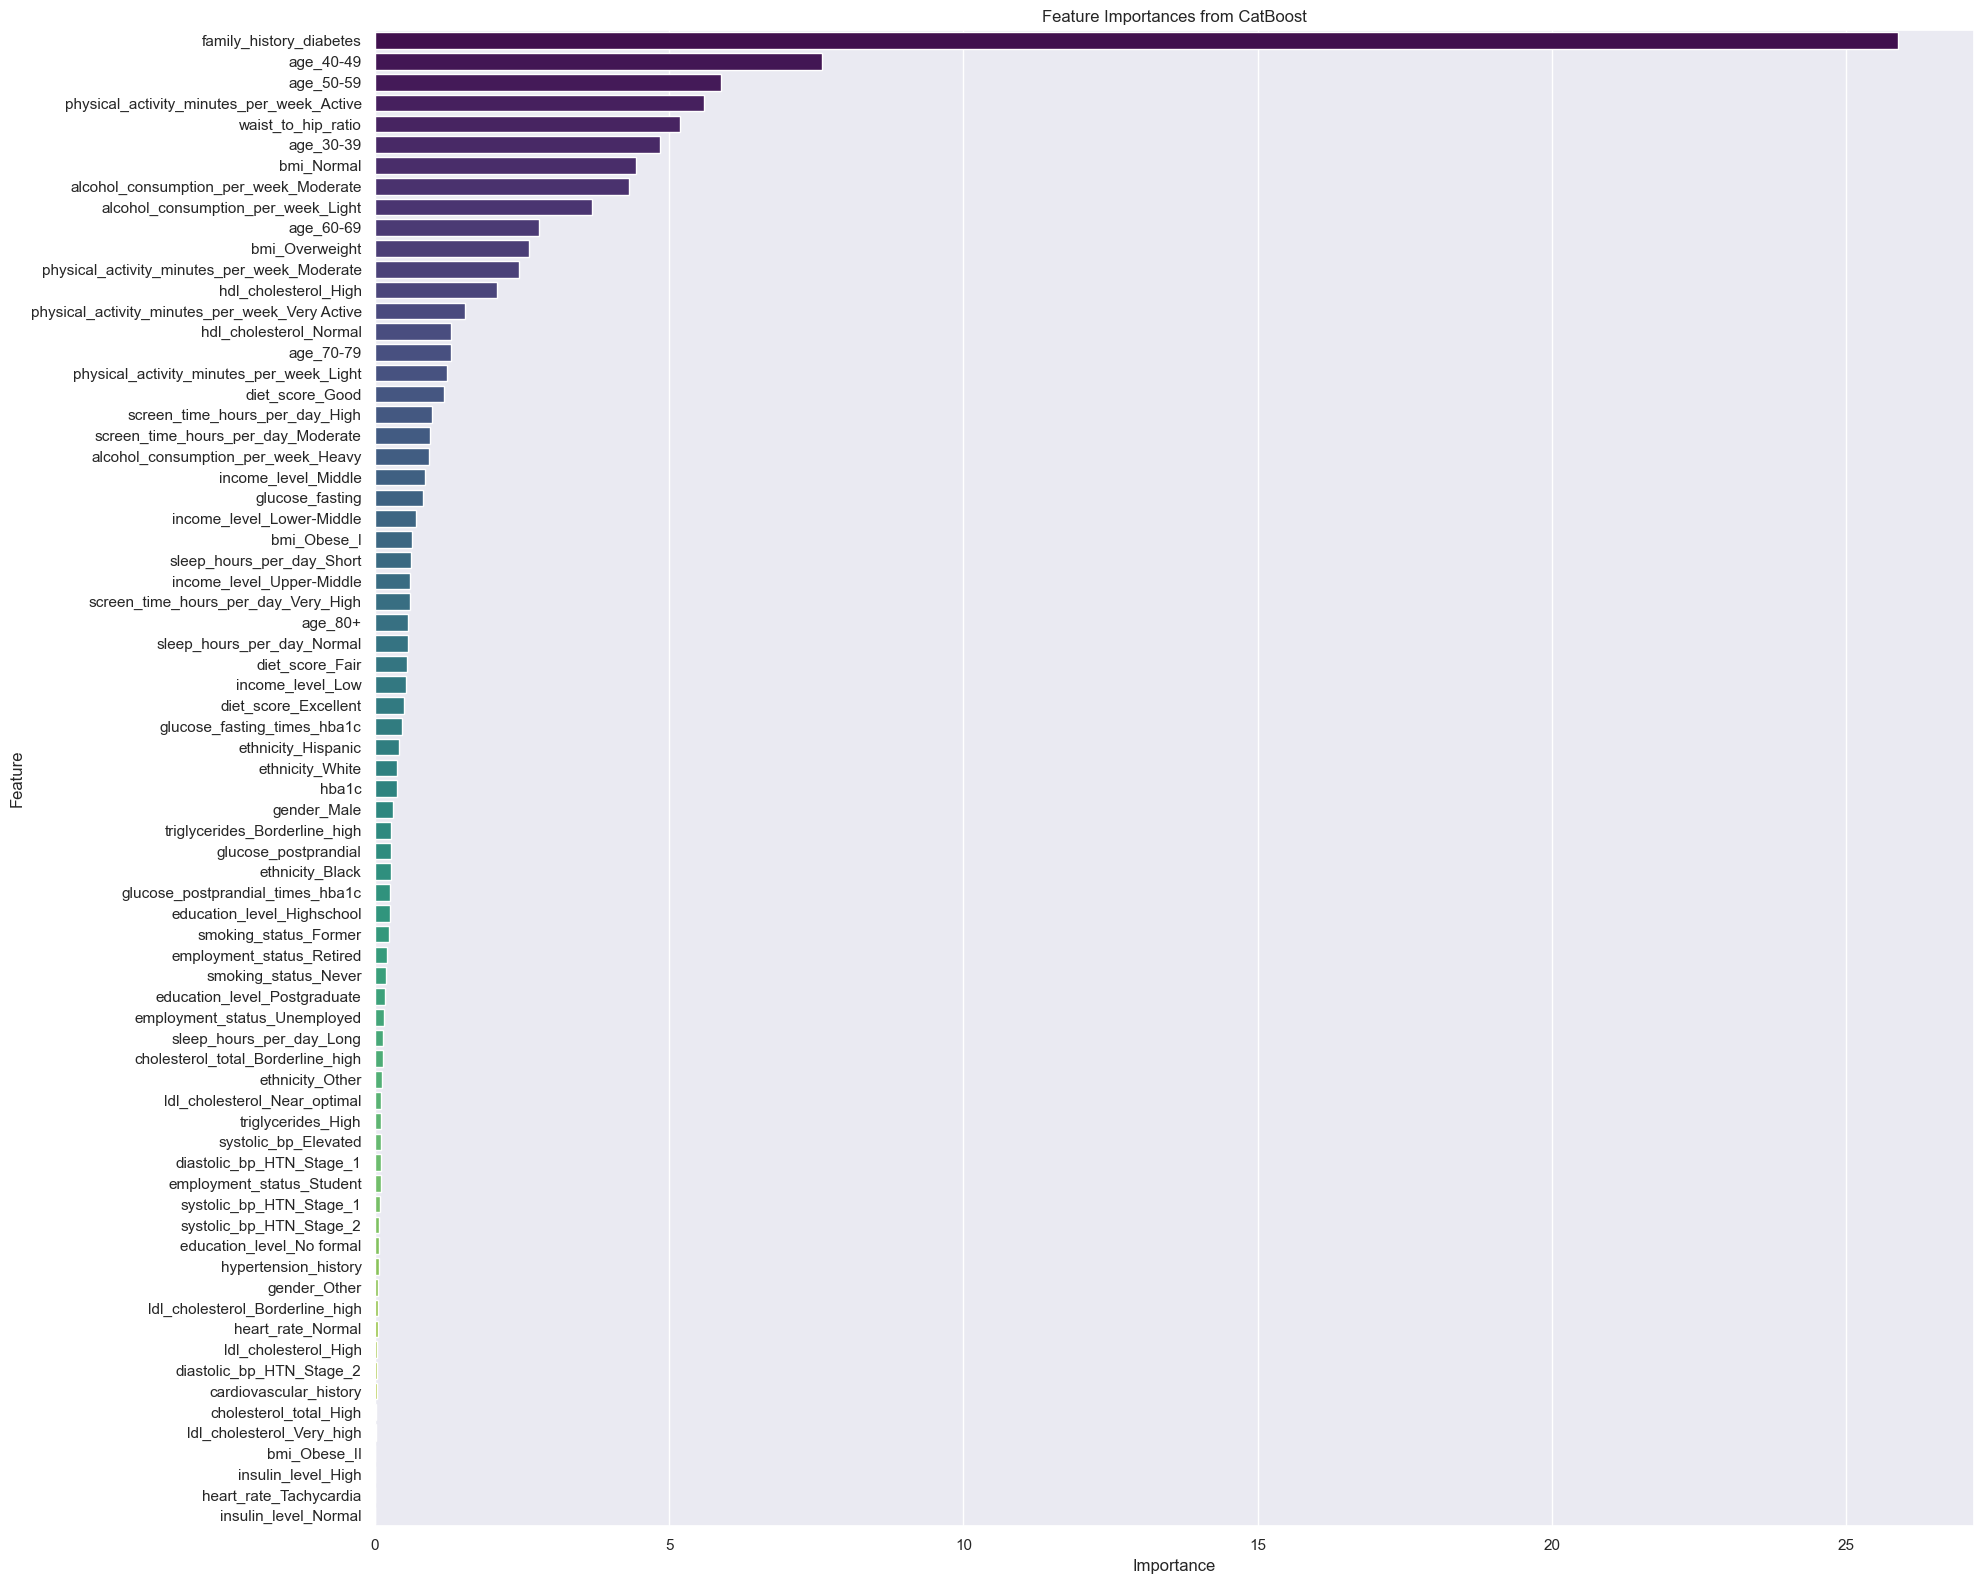

In [9]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(20, 16))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df,
    hue="Feature",
    legend=False,
    palette='viridis'
)

plt.title('Feature Importances from CatBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show();


In [34]:
chosen_columns = ["family_history_diabetes", "age_30-39", "age_40-49", "age_50-59", "age_60-69", "age_70-79", "age_80+", "physical_activity_minutes_per_week_Moderate", "physical_activity_minutes_per_week_Active", "physical_activity_minutes_per_week_Very Active", "bmi_Normal", "bmi_Overweight", "bmi_Obese_I", "bmi_Obese_II", "waist_to_hip_ratio", "alcohol_consumption_per_week_Light", "alcohol_consumption_per_week_Moderate", "alcohol_consumption_per_week_Heavy"]

Let's retrain with these columns.

In [35]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df2[chosen_columns],
    df2["diabetes_risk_score"],
    test_size=0.2,
    random_state=2025,
    stratify=df2["diabetes_risk_score"]
)

In [36]:
ratio = {0: n_low, 1: round(n_high * 5)}

smt = oversampling.SMOTE(sampling_strategy=ratio, random_state=2025)

X_train2, y_train2 = smt.fit_resample(X_train2, y_train2)

print("After resampling:")
print(y_train2.value_counts())

After resampling:
diabetes_risk_score
0    67249
1    63755
Name: count, dtype: int64


In [37]:
cat_untuned2 = CatBoostClassifier(random_seed=2025, verbose=0)
cat_untuned2.fit(X_train2, y_train2)

y_train_pred2 = cat_untuned2.predict(X_train2)
y_test_pred2 = cat_untuned2.predict(X_test2)

Training Set Metrics:


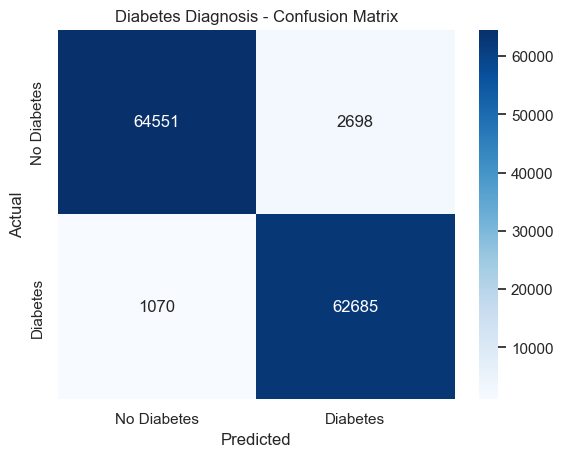

Accuracy: 0.9712375194650545
Precision: 0.9587354511111451
Recall: 0.9832170025880324
F1 Score: 0.970821911443572


Test Set Metrics:


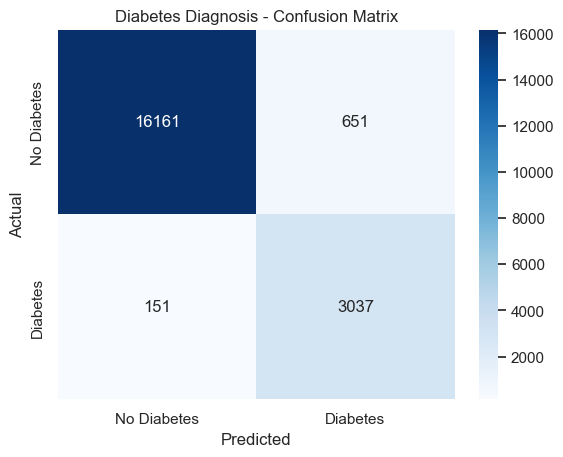

Accuracy: 0.9599
Precision: 0.8234815618221258
Recall: 0.9526348808030113
F1 Score: 0.8833624200116347


In [38]:
evaluate_metrics(y_train2, y_train_pred2, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test2, y_test_pred2, "Test Set Metrics:")

Performance is a bit lower, but we needed a lot less features to get it. Let's try to search for better hyperparameters to get the f1 score above 0.9.

In [39]:
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'bagging_temperature': [0, 0.2, 0.5, 0.8, 1],
    'iterations': [500, 1000, 1500]
}

cbc = CatBoostClassifier(eval_metric='F1', verbose=0)
random_search = RandomizedSearchCV(
    cbc, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1
)

random_search.fit(X_train2, y_train2)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 10, 'bagging_temperature': 0}


In [40]:
model2 = CatBoostClassifier(**best_params, random_seed=2025, verbose=0)
model2.fit(X_train2[chosen_columns], y_train2)

y_train_pred2 = model2.predict(X_train2[chosen_columns])
y_test_pred2 = model2.predict(X_test2[chosen_columns])

Training Set Metrics:


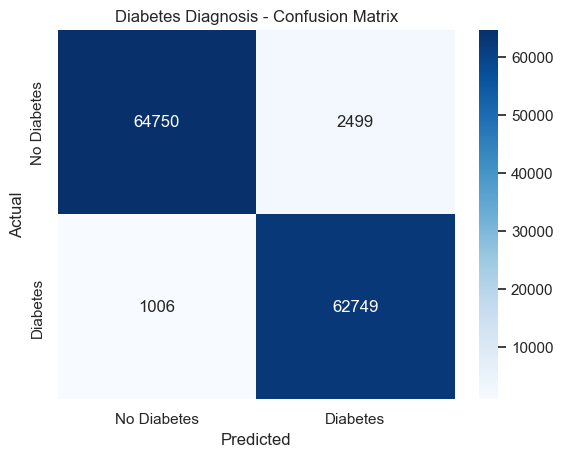

Accuracy: 0.9732450917529236
Precision: 0.9616999754781755
Recall: 0.9842208454238883
F1 Score: 0.9728300892227313


Test Set Metrics:


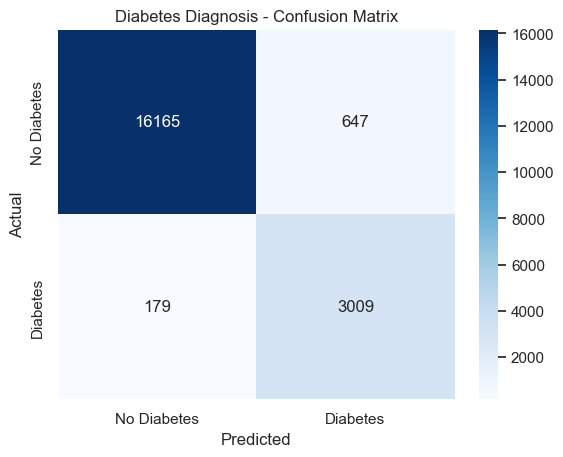

Accuracy: 0.9587
Precision: 0.8230306345733042
Recall: 0.9438519447929736
F1 Score: 0.8793103448275862


In [41]:
evaluate_metrics(y_train2, y_train_pred2, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test2, y_test_pred2, "Test Set Metrics:")

It looks like the untuned version was actually better.

In [42]:
model2 = cat_untuned2.copy()

In [44]:
y_train_pred2 = model2.predict(X_train2[chosen_columns])
y_test_pred2 = model2.predict(X_test2[chosen_columns])

In [46]:
y_train_pred_proba2 = model2.predict_proba(X_train2[chosen_columns])[:, 1]
y_test_pred_proba2 = model2.predict_proba(X_test2[chosen_columns])[:, 1]

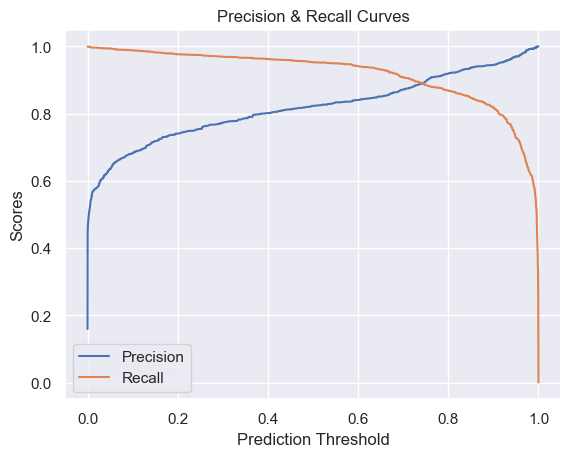

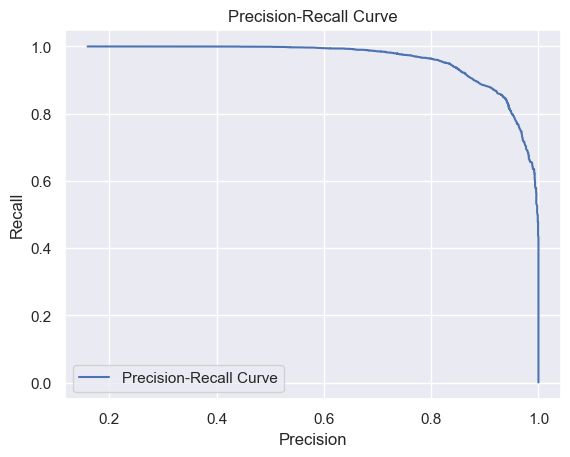

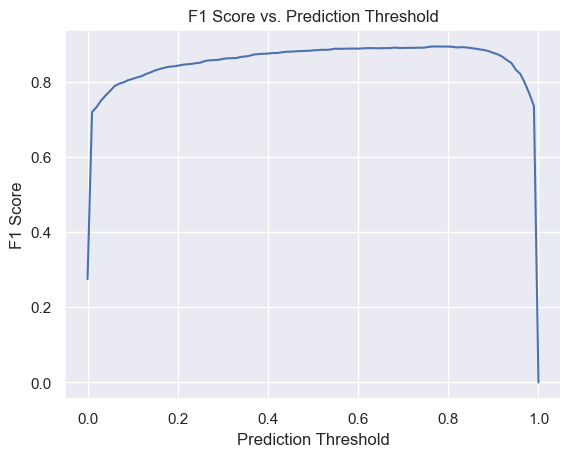

Optimal threshold: 0.77


In [47]:
thresh2 = optimize_threshold(y_test2, y_test_pred_proba2)
print(f"Optimal threshold: {thresh2}")

In [48]:
preds_train2 = y_train_pred_proba2 >= thresh2
preds_test2 = y_test_pred_proba2 >= thresh2

Training Set Metrics with Optimized Threshold:


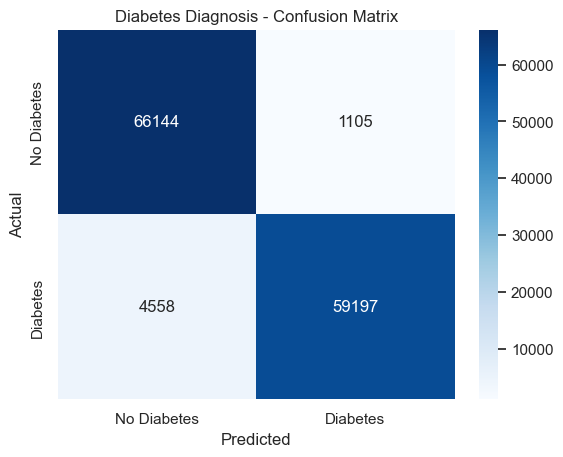

Accuracy: 0.9567723122958077
Precision: 0.9816755663162084
Recall: 0.9285075680338797
F1 Score: 0.9543516286868133


Test Set Metrics with Optimized Threshold:


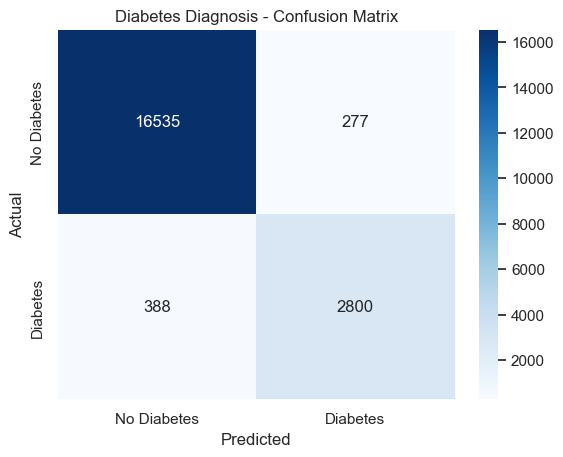

Accuracy: 0.96675
Precision: 0.9099772505687358
Recall: 0.8782936010037641
F1 Score: 0.8938547486033519


In [49]:
evaluate_metrics(y_train2, preds_train2, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test2, preds_test2, "Test Set Metrics with Optimized Threshold:")

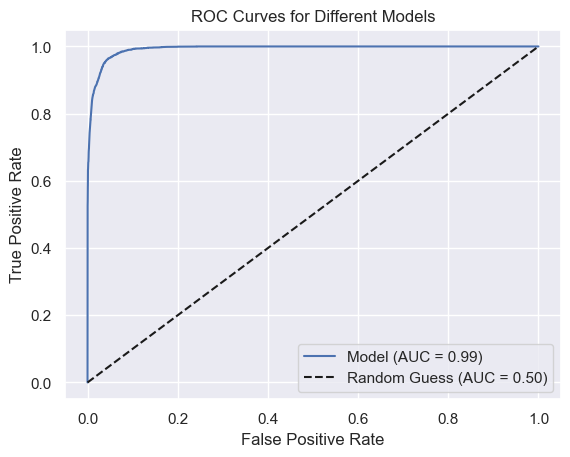

In [50]:
plot_roc_curve(y_test2, y_test_pred_proba2)

This performance is acceptable. Let's test the shap values.

In [51]:
explainer2 = shap.TreeExplainer(model2)
shap_values2 = explainer2.shap_values(X_test2.sample(100, random_state=42))
shap_df2 = pd.DataFrame(shap_values2, columns=chosen_columns)
shap_df2.head()

,family_history_diabetes,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,age_80+,physical_activity_minutes_per_week_Moderate,physical_activity_minutes_per_week_Active,physical_activity_minutes_per_week_Very Active,bmi_Normal,bmi_Overweight,bmi_Obese_I,bmi_Obese_II,waist_to_hip_ratio,alcohol_consumption_per_week_Light,alcohol_consumption_per_week_Moderate,alcohol_consumption_per_week_Heavy
0,-8.231086,0.141155,0.085606,-0.025854,1.331783,-0.413112,-0.332872,0.395996,-3.393309,0.090346,-1.083032,-0.389656,-0.158704,-0.016571,-2.031591,-0.432629,-0.114557,-0.020087
1,-8.366675,0.522322,0.903427,0.606859,-0.285329,3.898045,-0.336388,0.706676,1.250897,0.199451,1.180336,0.399482,-0.178870,-0.016847,-2.292385,-0.086107,-0.040998,-0.037082
2,-7.565046,0.371561,0.324468,0.179190,1.385035,-0.431779,-0.334569,0.412365,-3.854411,0.125767,1.042213,0.146307,-0.147851,-0.017265,0.648738,0.277072,0.131309,0.000136
3,-6.430575,0.448278,0.785486,0.334588,-0.356798,-0.644370,-0.478848,-2.141738,0.731255,0.179022,1.126572,0.210171,-0.149708,-0.011771,0.178672,-0.078545,-0.224925,0.032916
4,7.413829,0.092094,-0.455305,-1.345310,-1.388042,-1.070621,-0.575270,-1.611579,0.671137,0.162625,-0.911848,-0.352897,-0.246726,-0.010886,-0.711156,-0.006720,-0.053267,0.025854


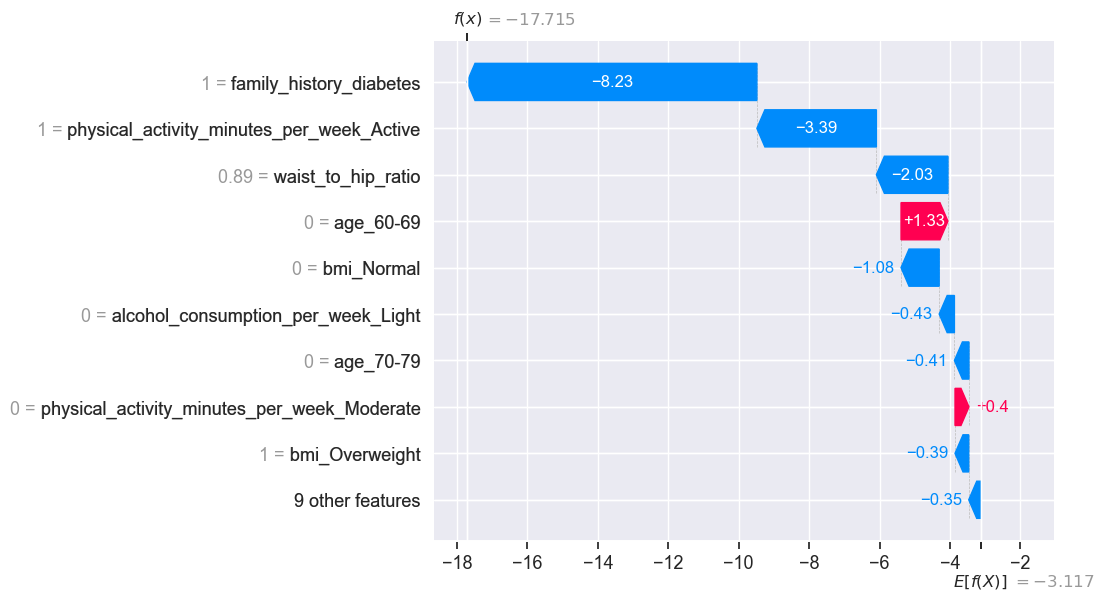

In [65]:
# create a SHAP Explanation object for a single sample and plot the waterfall
idx = range(10000)[0]  # first sample in the SHAP values

# idx = 4  # first sample in the SHAP values

base = explainer2.expected_value
# if expected_value is an array (e.g. per-class), use the positive class value
if hasattr(base, "__len__") and len(base) > 1:
	base = base[1]

exp = shap.Explanation(
	values=shap_values2[idx],
	base_values=base,
	data=X_test2.iloc[idx].values,
	feature_names=list(X_test2.columns)
)

shap.plots.waterfall(exp)

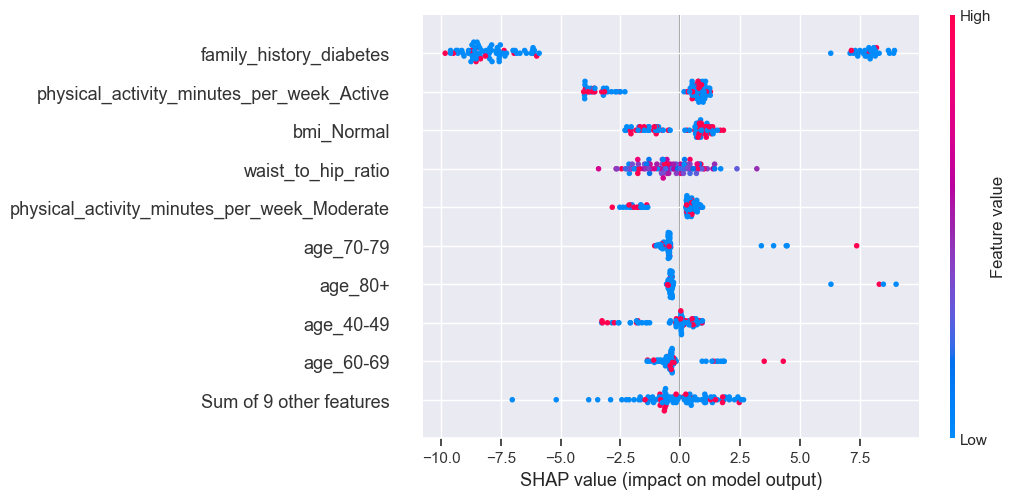

In [66]:
idx = list(range(1, 100))
base = explainer2.expected_value

if hasattr(base, "__len__") and len(base) > 1:
	base = base[1]

exp = shap.Explanation(
	values=shap_values2[idx],
	base_values=base,
	data=X_test2.iloc[idx].values,
	feature_names=list(X_test2.columns)
)

shap.plots.beeswarm(exp)

All works well. Let's save the model.

In [67]:
joblib.dump(model2, "models/model2.pkl")

['models/model2.pkl']